In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import (classification_report, multilabel_confusion_matrix, 
                             accuracy_score, recall_score, precision_score, 
                             f1_score, classification_report, ConfusionMatrixDisplay)

import tensorflow
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

colab = True  # Type True if using Google Colab, type False if using Jupyter Notebook
if colab:
    from google.colab import drive
    from zipfile import ZipFile

tensorflow.random.set_seed(42)


In [2]:
# Mounting Google Drive for use with Google Colab

if colab:
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Creating file paths for use with Google Colab
if colab:
    images = 'drive/MyDrive/dog_breed_classifier/Images.zip'

    with ZipFile(images, 'r') as train_images:
        train_images.extractall()
        print('Unzipped Train Images file')

if colab:
    train_data_dir = './Images'
else:
    train_data_dir = './Images/'

Unzipped Train Images file


In [4]:
if colab:
    images = 'drive/MyDrive/dog_breed_classifier/Testing_images.zip'

    with ZipFile(images, 'r') as train_images:
        train_images.extractall()
        print('Unzipped testing Images file')

if colab:
    test_data_dir = './Testing_images'
else:
    train_data_dir = './Testing_images/'

Unzipped testing Images file


## Setting up training and validation data

In [5]:
img_width, img_height = 224, 224 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)


In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 17230 images belonging to 120 classes.
Found 4255 images belonging to 120 classes.


In [21]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
breeds = list(train_generator.class_indices.keys())

#### Let's look at the dog breed 

In [22]:
print(f'There are a total of {num_classes} breeds in the dataset')
print('The breeds include: ', breeds)

There are a total of 120 breeds in the dataset
The breeds include:  ['Affenpinscher', 'Afghan', 'African Wild Dog', 'Airedale', 'American Staffordshire Terrier', 'Appenzeller', 'Australian Terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington Terrier', 'Bernese Mountain Dog', 'Black-and-Tan Coonhound', 'Blenheim Spaniel', 'Bloodhound', 'Bluetick', 'Border Collie', 'Border Terrier', 'Borzoi', 'Boston Bull', 'Bouvier Des Flandres', 'Boxer', 'Brabancon Griffon', 'Briard', 'Brittany Spaniel', 'Bull Mastiff', 'Cairn', 'Cardigan', 'Chesapeake Bay Retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker Spaniel', 'Collie', 'Curly Coated Retriever', 'Dandie Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English Foxhound', 'English Setter', 'English Springer', 'Entlebucher', 'Eskimo Dog', 'Flat Coated Retriever', 'French Bulldog', 'German Shepherd', 'German Short Haired Pointer', 'Giant Schnauzer', 'Golden Retriever', 'Gordon Setter', 'Great Dane', 'Great Pyrenees', 'Greater Swiss Mountain Dog', 'Groenenda

## Model Setup 

We are using a pre-trained model called InceptionV3, which is an image recognition model which has been shown to attain greater than 78% accuracy on the ImageNet dataset.  

In [23]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
InceptionV3.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)           

Below, I will be 'freezing' the layers from InceptionV3, this is done to avoid destroying any of the information they contrain during future training rouncs. 

We are also adding a GlobalAveragePooling layer and a dropout layer for regularization. 

In [24]:
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(120,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


## Model Training

In [25]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

We are further adding early stop as well as reduceLR to avoid overfitting the model

In [26]:
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [earlystop, reduceLR]

In [27]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30
269/269 [==============================] - 297s 1s/step - loss: 3.4171 - accuracy: 0.2852 - val_loss: 1.6684 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoch 2/30
269/269 [==============================] - 296s 1s/step - loss: 1.5400 - accuracy: 0.6444 - val_loss: 0.9430 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 3/30
269/269 [==============================] - 294s 1s/step - loss: 1.1436 - accuracy: 0.7002 - val_loss: 0.7802 - val_accuracy: 0.7841 - lr: 1.0000e-04
Epoch 4/30
269/269 [==============================] - 373s 1s/step - loss: 0.9930 - accuracy: 0.7242 - val_loss: 0.7156 - val_accuracy: 0.7955 - lr: 1.0000e-04
Epoch 5/30
269/269 [==============================] - 378s 1s/step - loss: 0.9376 - accuracy: 0.7348 - val_loss: 0.6837 - val_accuracy: 0.7985 - lr: 1.0000e-04
Epoch 6/30
269/269 [==============================] - 379s 1s/step - loss: 0.8895 - accuracy: 0.7418 - val_loss: 0.6675 - val_accuracy: 0.8004 - lr: 1.0000e-04
Epoch 7/30
269/269 [====================

In [28]:

(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

67/67 [==============================] - 45s 663ms/step - loss: 0.6287 - accuracy: 0.8087
Validation Loss:  0.6287146210670471
Validation Accuracy:  0.8086956739425659


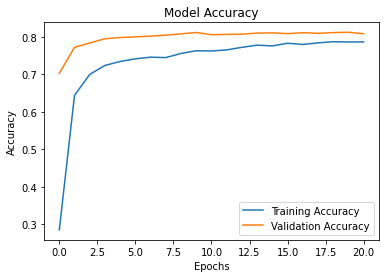

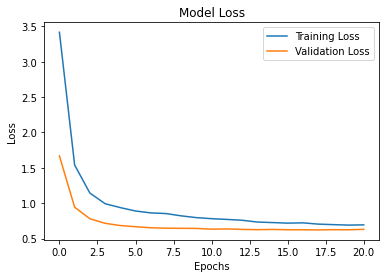

In [29]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [30]:
model.save('./drive/MyDrive/dog_breed_classifier/model_data_softmax/')

INFO:tensorflow:Assets written to: ./drive/MyDrive/dog_breed_classifier/model_data_softmax/assets


## Model Metrics Overview 

In [31]:
test_data_path = './Testing_images'

In [32]:
test_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [33]:
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle=False
)

Found 3633 images belonging to 120 classes.


In [41]:
preds = model.predict(test_generator)
preds_encoded = np.argmax(preds, axis=1)

In [42]:
preds_encoded

array([  0,   0,   0, ..., 119,  26, 119])

In [36]:
label_names = list(test_generator.class_indices.keys())

In [40]:
y_true = test_generator.classes

In [43]:
print(classification_report(y_true, preds_encoded, target_names=label_names))

                                precision    recall  f1-score   support

                 Affenpinscher       0.76      1.00      0.87        13
                        Afghan       0.98      0.98      0.98        50
              African Wild Dog       0.98      1.00      0.99        50
                      Airedale       0.92      0.92      0.92        50
American Staffordshire Terrier       0.81      0.92      0.86        50
                   Appenzeller       1.00      0.33      0.50        12
            Australian Terrier       0.50      1.00      0.67        12
                       Basenji       0.96      1.00      0.98        50
                        Basset       0.98      0.96      0.97        50
                        Beagle       0.94      0.94      0.94        50
            Bedlington Terrier       1.00      1.00      1.00        13
          Bernese Mountain Dog       1.00      0.96      0.98        50
       Black-and-Tan Coonhound       0.71      0.91      0.80  

This is a reliable model that is achieving high precision and high recal scores across 120 breeds. With several breeds, the model has a precision score of 1, and/or a recall score of 1. The accuracy score for the overall model is 0.86. Please refer to the next notebook for a misclassification analysis and next steps. 